# It works, we need to add a dvergence free constraint!!!

In [1]:
from ngsolve import *
from netgen.occ import *
from ngsolve.webgui import Draw

In [2]:
shape = Box((-1,-1,-1), (1,1,1)) # create a box
geo = OCCGeometry(shape) # create a geometry from the box
mesh = Mesh(geo.GenerateMesh(maxh=0.2)) # create a mesh from the geometry
Draw (mesh); # draw the mesh

WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 1, 'order3d': 1, 'draw_vol': None…

In [3]:
order = 2
Hcc = HCurlCurl(mesh, order=order) # for the gamma variable
Hdd = HDivDiv(mesh, order=order) # , orderinner=order+1) fr t
# fesalpha = H1(mesh, order=order+1) # , dirichlet=".*")
Hc = HCurl(mesh, order=order) # for the div of a Hdd field


k , dk= Hdd.TnT() 
p, dp = Hc.TnT()
g, dg = Hcc.TnT()

In [4]:
n = specialcf.normal(3)
t = specialcf.tangential(3, True)
bbndtang  = specialcf.EdgeFaceTangentialVectors(3)
tef1 = bbndtang[:,0]
tef2 = bbndtang[:,1]
nu1 = Cross(tef1,t)
nu2 = Cross(tef2,t)

def IncOp(g, dg):
    return InnerProduct(curl(g), curl(dg).trans)*dx \
        + (curl(g)*n) * Cross (dg*n, n) * dx(element_vb=BND) \
        + (curl(dg)*n) * Cross (g*n, n) * dx(element_vb=BND) \
        + (g[nu1,t]*dg[t,tef1]-g[nu2,t]*dg[t,tef2])*dx(element_vb=BBND)

# print ( (gamma*nu1*t)*(dgamma*t*tef1))

def J(g): return g - 0.5*Trace(g)*Id(3)

def Constraint(k, p):
    return InnerProduct(k, Grad(p))*dx - (k*n*n) * (p*n) * dx(element_vb=BND)

def Curl(u):
    if u.dim == 3:
        return CF( (u[1].Diff(z)- u[2].Diff(y), u[2].Diff(x)- u[0].Diff(z), u[0].Diff(y)- u[1].Diff(x)) )
    if u.dim == 9:
        return CF( (Curl(u[0,:]),Curl(u[1,:]),Curl(u[2,:])),dims=(3,3) )

def Transpose(u):
    return CF( (u[0,0] , u[1,0] , u[2,0] , u[0,1] , u[1,1] , u[2,1] , u[0,2] , u[1,2] , u[2,2] ),dims=(3,3) )

def Symetric(u): return u + Transpose(u) 

In [5]:

MINC = BilinearForm(IncOp(g,dg))

Mcc = BilinearForm(InnerProduct(g, dg)*dx)
Mdd = BilinearForm(InnerProduct(k, dk)*dx)

Mccdd = BilinearForm(trialspace=Hcc, testspace=Hdd)
Mccdd += InnerProduct(g, dk)*dx

MJdd = BilinearForm(trialspace=Hdd, testspace=Hdd)
MJdd += InnerProduct(k, dk)*dx-0.5*Trace(k)*Trace(dk)*dx

with TaskManager():
    MINC.Assemble()
    Mcc.Assemble()
    Mdd.Assemble()
    Mccdd.Assemble()
    MJdd.Assemble()



In [6]:

fes = Hdd*Hc
k, p = fes.TrialFunction()
dk, dp = fes.TestFunction()

PROJ = BilinearForm(fes)
PROJ += InnerProduct(k, dk)*dx
PROJ += Constraint(k, dp)
PROJ += Constraint(dk, p)
PROJ += curl(p)*curl(dp)*dx- 1e-6*p*dp*dx # I don't know why this is needed, 

MASS = BilinearForm(fes)
MASS += InnerProduct(k, dk)*dx
with TaskManager():
    PROJ.Assemble() 
    MASS.Assemble()

In [7]:
# 3 minutes for a cube of size 2 and a mesh of size 0.2 and order 3
with TaskManager():
    inv_PROJ = PROJ.mat.Inverse(inverse="sparsecholesky", freedofs=fes.FreeDofs())
    inv_Mcc = Mcc.mat.Inverse(inverse="sparsecholesky", freedofs=fes.FreeDofs())
    inv_Mdd = Mdd.mat.Inverse(inverse="sparsecholesky", freedofs=fes.FreeDofs())

In [8]:
peak = exp(-25*(x*x+y*y+z*z))/100
cf_gamma = CF((0,0,0, 0,peak,0,  0,0,-peak), dims=(3,3))

cf_symcurl_gamma = Symetric(Curl(cf_gamma))
Draw(InnerProduct(cf_symcurl_gamma,cf_symcurl_gamma), mesh, "SCGamma", clipping={"z": -1})


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

BaseWebGuiScene

In [9]:
gf_g = GridFunction(Hcc)
gf_inc_g = GridFunction(Hcc)

peak = exp(-10*(x*x+y*y+z*z))/1000
cf_gamma = CF((peak,0,0, 0,0,0,  0,0,0), dims=(3,3))
cf_symcurl_gamma = Symetric(Curl(cf_gamma))

print(" total magnitude")
Draw(InnerProduct(cf_symcurl_gamma,cf_symcurl_gamma), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (x,x) component")
Draw(InnerProduct(cf_symcurl_gamma[0,0],cf_symcurl_gamma[0,0]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (x,y) component")
Draw(InnerProduct(cf_symcurl_gamma[0,1],cf_symcurl_gamma[0,1]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (x,z) component")
Draw(InnerProduct(cf_symcurl_gamma[0,2],cf_symcurl_gamma[0,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (y,y) component")
Draw(InnerProduct(cf_symcurl_gamma[1,1],cf_symcurl_gamma[1,1]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (y,z) component")
Draw(InnerProduct(cf_symcurl_gamma[1,2],cf_symcurl_gamma[1,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (z,z) component")
Draw(InnerProduct(cf_symcurl_gamma[2,2],cf_symcurl_gamma[2,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})







 total magnitude


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (x,x) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (x,y) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (x,z) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (y,y) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (y,z) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (z,z) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

BaseWebGuiScene

In [10]:

gf_g.Set( cf_symcurl_gamma, dual=True, bonus_intorder=12)

gf_k = GridFunction(Hdd)
gf_J_k = GridFunction(Hdd)





In [11]:
print ("gamma\n")
scene1 = Draw (InnerProduct(gf_g,gf_g), mesh, draw_surf=False, clipping={"x": -1, "y": 0, "z": 0})
print ("inc gamma\n")
scene2 = Draw (InnerProduct(gf_inc_g,gf_inc_g), mesh, draw_surf=False, clipping={"x": -1, "y": 0, "z": 0})
print ("kappa \n")
scene3 = Draw (InnerProduct(gf_k, gf_k), mesh, draw_surf=False, clipping={"x": -1, "y": 0, "z": 0})
print ("J kappa\n")
scene4 = Draw (InnerProduct(gf_J_k, gf_J_k), mesh, draw_surf=False, clipping={"x": -1, "y": 0, "z": 0})

gamma



WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

inc gamma



WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

kappa 



WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

J kappa



WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

In [12]:

w0 = - 2**-(1/3)/(2-2**-(1/3))
w1 = 1/(2-2**-(1/3))

c= [w0/2 , (w0+w1)/2  , (w0+w1)/2 , w0/2 ]
d= [w1,w0,w1]

MKK= inv_Mcc @ Mccdd.mat.T @ inv_Mdd @ MJdd.mat 
MGG = inv_Mdd @ Mccdd.mat @ inv_Mcc @ MINC.mat


Energy = []
dt = 0.1e-2
final_time = 0.2
with TaskManager():
  for i in range(round(final_time/dt)):
    NORM = Norm(gf_g.vec)
    Energy.append(NORM)
    #if NORM > 1.3:
    #  break

    print ("t = ", i*dt, "norm = ",NORM)

    
    gf_g.vec.data += c[0]*dt*MKK*gf_k.vec
    gf_k.vec.data += d[0]*dt*MGG*gf_g.vec

    gf_g.vec.data += c[1]*dt*MKK*gf_k.vec
    gf_k.vec.data += d[1]*dt*MGG*gf_g.vec

    gf_g.vec.data += c[2]*dt*MKK*gf_k.vec
    gf_k.vec.data += d[2]*dt*MGG*gf_g.vec 

    gf_g.vec.data += c[3]*dt*MKK*gf_k.vec

    if i % 10 == 0:
        scene1.Redraw()
        #scene2.Redraw()
        scene3.Redraw()
        #scene4.Redraw()
        # scene5.Redraw()


t =  0.0 norm =  0.002155352594744468
t =  0.001 norm =  0.0021553198209225788
t =  0.002 norm =  0.0021552215028463424
t =  0.003 norm =  0.002155057650683438
t =  0.004 norm =  0.00215482828137789
t =  0.005 norm =  0.002154533418646989
t =  0.006 norm =  0.00215417309297691
t =  0.007 norm =  0.00215374734161717
t =  0.008 norm =  0.0021532562085738592
t =  0.009000000000000001 norm =  0.002152699744601747
t =  0.01 norm =  0.002152078007195187
t =  0.011 norm =  0.0021513910605779935
t =  0.012 norm =  0.002150638975692205
t =  0.013000000000000001 norm =  0.0021498218301858533
t =  0.014 norm =  0.0021489397083997485
t =  0.015 norm =  0.0021479927013533535
t =  0.016 norm =  0.002146980906729783
t =  0.017 norm =  0.0021459044288599963
t =  0.018000000000000002 norm =  0.002144763378706249
t =  0.019 norm =  0.0021435578738448467
t =  0.02 norm =  0.002142288038448298
t =  0.021 norm =  0.002140954003266909
t =  0.022 norm =  0.002139555905609893
t =  0.023 norm =  0.002138093889

In [13]:
#PEAK = CF((peak,0,0, 0,peak,0,  0,0,peak), dims=(3,3))
Draw (InnerProduct(gf_g - cf_symcurl_gamma,gf_g - cf_symcurl_gamma) , mesh, draw_surf=False, clipping={ "x" : -1 })

WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

BaseWebGuiScene

In [14]:
print(" total magnitude")
Draw(InnerProduct(gf_g,gf_g), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (x,x) component")
Draw(InnerProduct(gf_g[0,0],gf_g[0,0]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (x,y) component")
Draw(InnerProduct(gf_g[0,1],gf_g[0,1]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (x,z) component")
Draw(InnerProduct(gf_g[0,2],gf_g[0,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (y,y) component")
Draw(InnerProduct(gf_g[1,1],gf_g[1,1]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (y,z) component")
Draw(InnerProduct(gf_g[1,2],gf_g[1,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})
print(" (z,z) component")
Draw(InnerProduct(gf_g[2,2],gf_g[2,2]), mesh, "SCGamma", clipping={"x": -1, "y": 0, "z": 0})



 total magnitude


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (x,x) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (x,y) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (x,z) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (y,y) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (y,z) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

 (z,z) component


WebGuiWidget(value={'ngsolve_version': '6.2.2203', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'draw_vol': True…

BaseWebGuiScene

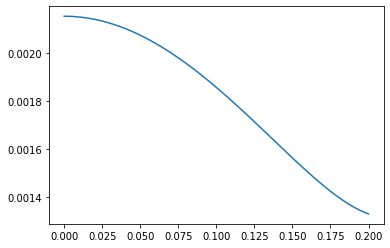

In [15]:
import matplotlib.pyplot as plt
import numpy as np

TIME = np.linspace(0,final_time,len(Energy))
plt.plot(TIME,Energy)